# Import Libraries

## Target:

Reduce the number of parameters to < 8K and maintain acuracy
- Reduced the channel dimesnions
- Reduced convolutions whne size was at 6x6
- Removed dropouts after 2 convolution layers as it was underfitting

## Results:
- Parameters: 7614 parameters
- Best Train Accuracy: 99.05
- Best Test Accuracy: 99.46

## Analysis:
- Reducing dropouts helped with overcoming nunderfitting 
- Last 4 epochs have an average accuracy of 99.40%.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [5]:
def batch_norm(bn_type,channels):
  if bn_type == 'GN':
    return nn.GroupNorm(2,channels)
  elif bn_type == 'LN':
    return nn.GroupNorm(1,channels)
  elif bn_type == 'BN':
    return nn.BatchNorm2d(channels)

# The model
Let's start with the model we first saw

In [6]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,bn_type,dropout_value):
        super(Net, self).__init__()

        self.bn_type = bn_type
        self.dropout = dropout_value
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            batch_norm(self.bn_type,10),
            nn.Dropout(self.dropout)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            batch_norm(self.bn_type,20),
            #nn.Dropout(self.dropout)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) 

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,20),
            nn.Dropout(self.dropout)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,12),
            #nn.Dropout(self.dropout)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,12),
            nn.Dropout(self.dropout)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            batch_norm(self.bn_type,16),
            nn.Dropout(self.dropout)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(self.dropout)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('GN',0.1).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
            Conv2d-8           [-1, 10, 24, 24]             200
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 20, 10, 10]           1,800
             ReLU-11           [-1, 20, 10, 10]               0
        GroupNorm-12           [-1, 20, 10, 10]              40
          Dropout-13           [-1, 20, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

    #return train_acc, train_losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    #return test_acc, test_loss

In [9]:
def display_misclassified_images(model):
  print("\n\n\n********* Misclassified Images **************\n\n\n")
  model.eval()

  # Create a test loader with batch size equal to test data length
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          # Get the indexes of images that are incorrectly classified
          indexes = (pred.view(-1,) != target.view(-1,)).nonzero()

          # Plot the misclassified images
          rows = np.ceil(len(indexes)/2)
          fig = plt.figure(figsize=(15, rows*4))
          for i, idx in enumerate(indexes[:10]):
              ax = fig.add_subplot(rows, 5, i+1)
              ax.imshow(data[idx].cpu().numpy().squeeze(), cmap='gray_r')
              ax.set_title(f"Target = {target[idx].item()} \n Predicted = {pred[idx].item()}")
          
          plt.show()

In [10]:
def train_test_display(bn_type, no_of_epochs):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  model =  Net(bn_type,0.1).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  #scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  # LR Scheduler
  lambda1 = lambda epoch: 0.85 ** epoch
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  for epoch in range(1,no_of_epochs):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch)
      scheduler.step()
      test(model, device, test_loader)
  
  display_misclassified_images(model)

  return test_acc, test_losses,train_acc,train_losses

In [11]:
EPOCHS = 16





# **Using Batch Normalization**

In [ ]:
print("\n\n\n********* Using Batch Normalization **************\n\n\n")
test_acc_bn, test_losses_bn,train_acc_bn,train_losses_bn = train_test_display('BN', EPOCHS)


  0%|          | 0/469 [00:00<?, ?it/s]




********* Using Batch Normalization **************



EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.013664048165082932 Batch_id=468 Accuracy=92.23: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9860/10000 (98.60%)

EPOCH: 2


Loss=0.01941320300102234 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.10010159760713577 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.029728004708886147 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.03485769405961037 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.039292700588703156 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:20<00:00, 22.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.018337322399020195 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:20<00:00, 22.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.03065839409828186 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.04814891144633293 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.02178492397069931 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.008374731056392193 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 22.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.11431794613599777 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.03934133052825928 Batch_id=97 Accuracy=99.08:  20%|██        | 95/469 [00:04<00:16, 23.02it/s] 

# **Using Layer Normalization**

  0%|          | 0/469 [00:00<?, ?it/s]




********* Using Layer Normalization **************



EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.108506940305233 Batch_id=468 Accuracy=88.99: 100%|██████████| 469/469 [00:20<00:00, 22.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9807/10000 (98.07%)

EPOCH: 2


Loss=0.03464631736278534 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.14186425507068634 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.045677971094846725 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


Loss=0.10959895700216293 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.06527245789766312 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.009660699404776096 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.0021208671387284994 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.006165847182273865 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.02029610052704811 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.05775364115834236 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.01867339387536049 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.03287868574261665 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9944/10000 (99.44%)

EPOCH: 14


Loss=0.005884220823645592 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.049410685896873474 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]



Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)




********* Misclassified Images **************





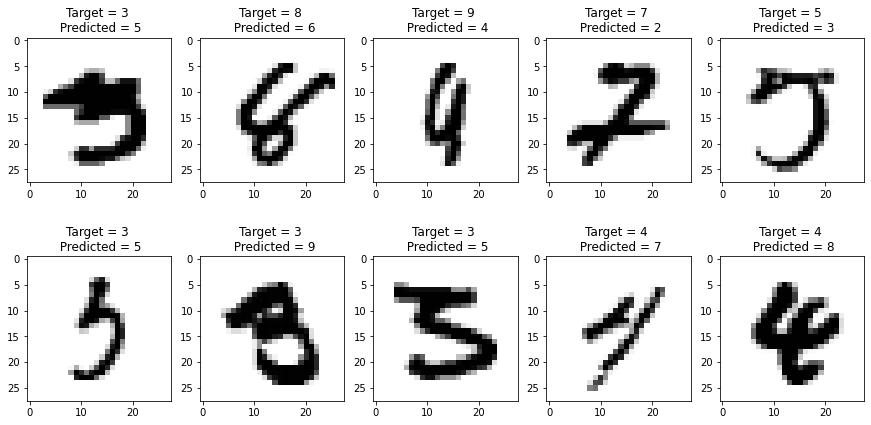

In [13]:
print("\n\n\n********* Using Layer Normalization **************\n\n\n")
test_acc_ln, test_losses_ln,train_acc_ln,train_losses_ln = train_test_display('LN', EPOCHS)

# **Using Group Normalization**

  0%|          | 0/469 [00:00<?, ?it/s]




********* Using Group Normalization **************



EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.11676424741744995 Batch_id=468 Accuracy=89.92: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Loss=0.1263328343629837 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.09819179773330688 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.013963491655886173 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:21<00:00, 22.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


Loss=0.021175416186451912 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


Loss=0.012652076780796051 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.009963988326489925 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.009944147430360317 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:21<00:00, 22.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.05874534323811531 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:21<00:00, 21.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 10


Loss=0.012423069216310978 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.017041033133864403 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:22<00:00, 21.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.0038643740117549896 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.05082830414175987 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.06333498656749725 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Loss=0.030918063595891 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]



Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)




********* Misclassified Images **************





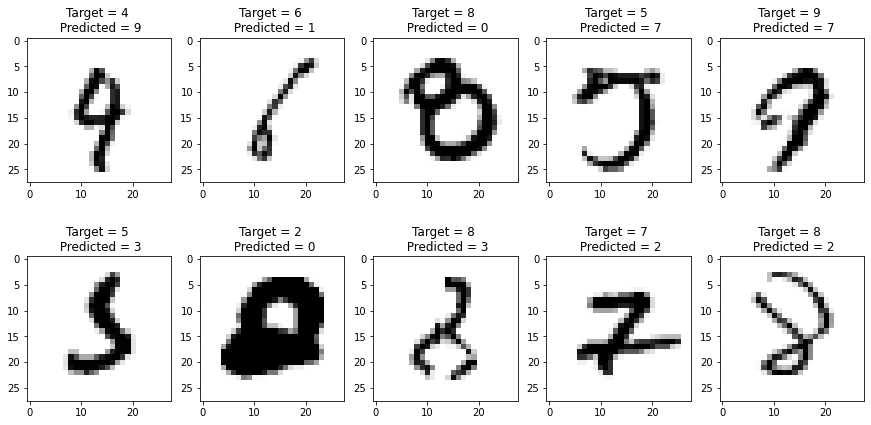

In [14]:
print("\n\n\n********* Using Group Normalization **************\n\n\n")
test_acc_ln, test_losses_ln,train_acc_ln,train_losses_ln = train_test_display('GN', EPOCHS)

# **Let's Plot graphs**



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs =[x for x in range(7035)]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(epochs,train_losses_bn,'-r',label='batch norm')
axs[0, 0].plot(epochs,train_losses_ln,'-b',label='layer norm')
axs[0, 0].plot(epochs,train_losses_gn,'-g',label='group norm')
axs[0, 0].legend(loc="upper right")
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(epochs,train_acc_bn,'r',label='batch norm')
axs[1, 0].plot(epochs,train_acc_ln,'b',label='layer norm')
axs[1, 0].plot(epochs,train_acc_gn,'g',label='group norm')
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Training Accuracy")

epochs =[x for x in range(15)]
axs[0, 1].plot(epochs,test_losses_bn,'r',label='batch norm')
axs[0, 1].plot(epochs,test_losses_ln,'b',label='layer norm')
axs[0, 1].plot(epochs,test_losses_gn,'g',label='group norm')
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(epochs,test_acc_bn,'r',label='batch norm')
axs[1, 1].plot(epochs,test_acc_ln,'b',label='layer norm')
axs[1, 1].plot(epochs,test_acc_gn,'g',label='group norm')
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Accuracy")